# Modelbase Tutorial

This is a **modelbase** tutorial. Modelbase is a Python based wrapper around the most useful commands that allow you to create a dynamic biological systems. It has been developed at the [Insitute for Quantitative and Theoretical Biology](http://www.qtb.hhu.de/) at the Heinrich-Heine University Düsseldorf, Germany. 

## Getting started

In [256]:
# Import the necessary packages
import modelbase
import matplotlib.pyplot as plt
import numpy as np

Every model is defined by:
- model variables,
- model parameters,
- rate equations,
- stoichiometries.

### Example 1: Modelling a simple chain of reactions
We apply modelbase to simulate a simple chain of three reactions with two state variables "X" and "Y".

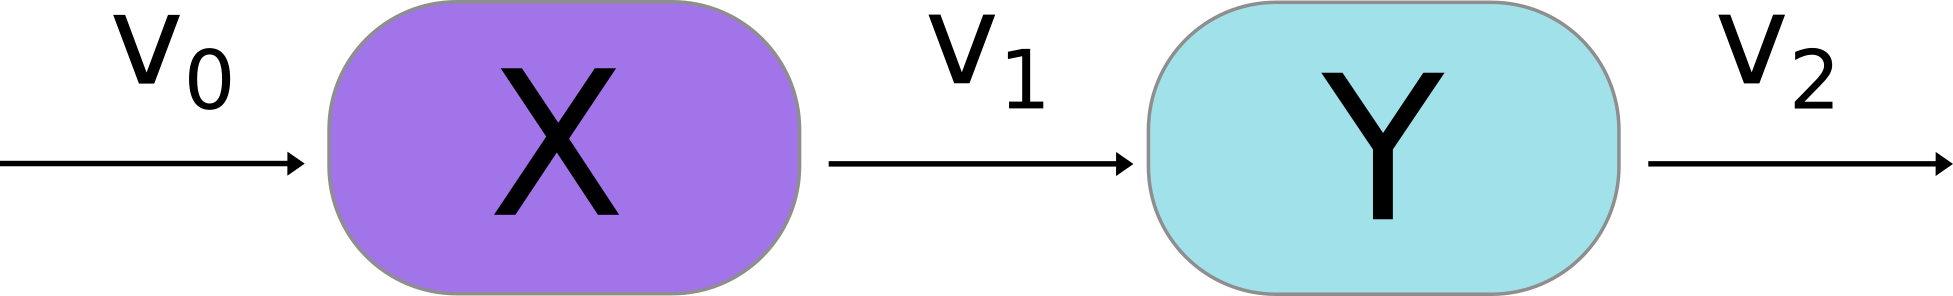

In [169]:
# Define metabolite species X and Y as a list
cl = ['X','Y']

Parameters:
- influx (v0),
- rate constant conversion X->Y (k1),
- rate constant for outflux (k2).

In [170]:
# Provide parameters in a form of dictionary
p = {'v0':1,
     'k1':0.5,
     'k2':0.1}

In [171]:
# Instantiate model and pass the parameters set
m = modelbase.Model(p)

The variables can now be accessed by ```m.par.name```

In [172]:
print('The rate of v0 is', m.par.v0)

The rate of v0 is 1


Model assumptions:
- constant influx of X, 
- reversible conversion of X to Y
- irreversible outflux of Y.

In [221]:
# Add the variables. Variables are ALWAYS defined by names (i.e. strings). 
# These are later used to access and identify the variables and their values.
m.set_cpds(cl)

To define the reaction rates we need to:
1. define a rate function
   - all the rate functions always accept the model parameters as first argument,
   - the remaining arguments are metabolite concentrations as defined in the ```set_rate``` command
2. define the stoichiometries
   - the stoichiometries can be defined by the rate: ```m.set_stoichiometry```
   - or by the compound name ```set_stoichiometry_byCpd```

In [222]:
# Define the reaction rate of the function that produces X
# It is particulary simple, because it is constant
# We set the rate by providing the name of the rate, function and compounds that are passed to the function (here none)
m.set_rate('v0',lambda p:p.v0)

We have used here Python's *lambda* expression. There are numbers of available lambda tutorials out there like [this](https://pythonspot.com/python-lambda/) or [this](https://www.python-course.eu/python3_lambda.php) but particularly nice is the [Stupid lambda tricks](http://p-nand-q.com/python/lambda.html) addressed to "wacky geek fun hackers".

In [223]:
# Define the reaction rate of the irreversible v1 where one X is consumed and one Y is produced
# We assume simple mass-action kinetics 
def v1(p,x):
    return p.k1*x

In [224]:
# Set the rate and pass to the v1 concentrations of X and Y
m.set_rate('v1',v1,'X')

In [225]:
# Define the reaction rate of the irreversible v2 and set the rate
# We (again) assume simple mass-action kinetics
def v2(p,y):
    return p.k2*y

m.set_rate('v2',v2,'Y')

In [226]:
# Set the stoichiometry of all three reactions 
m.set_stoichiometry('v0',{'X':1})
m.set_stoichiometry('v1',{'X':-1,'Y':1})
m.set_stoichiometry('v2',{'Y':-1})

In [227]:
# You can check the stoichiometries of the model with the special method
m.stoichiometries

{'v0': {'X': 1}, 'v1': {'X': -1, 'Y': 1}, 'v2': {'Y': -1}}

Mathematically, this results in the two model equations:

$\frac{dX}{dt} = v_0 - k_1*[X]$

$\frac{dY}{dt} = k_1*[X] - k_2*[Y]$

therefore it might be more intuitive to set the stoichiometry by the compound name, which is also supported by the modelbase.
```
m.set_stoichiometry_byCpd('X',{'v0':1, 'v1':-1})
m.set_stoichiometry_byCpd('Y',{'v1':1,'v2':-1})
```

To perform any type of simulations we create a new simulate object using ```modelbase.Simulate``` module

In [228]:
s = modelbase.Simulate(m)

There is a number of build in methods to integrate. The simplest one is the integration over a given period of time ```timeCourse```. The method takes as the first argument **time interval** and as a second the **initial conditions**, and returns an array of state variables Several optional arguments are available to customise the settings of the integration method. 

In [203]:
# Define time for integration
time = np.linspace(0,100,1000)

In [204]:
# Integrate
s.timeCourse(time,np.zeros(2))

array([[  0.00000000e+00,   0.00000000e+00],
       [  9.76363668e-02,   2.45549916e-03],
       [  1.90506303e-01,   9.62899685e-03],
       ..., 
       [  2.00000000e+00,   9.99942103e+00],
       [  2.00000000e+00,   9.99942679e+00],
       [  2.00000000e+00,   9.99943250e+00]])

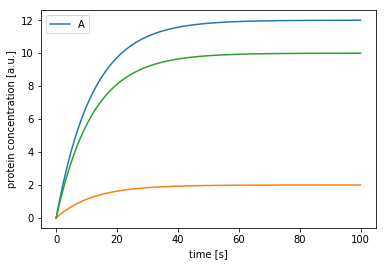

In [253]:
# Plot the temporal evolution of X and Y
plt.figure()
plt.plot(s.getT(),s.getY())
plt.legend(m.cpdNames)
plt.xlabel('time [s]')
plt.ylabel('protein concentration [a.u.]')
plt.draw_if_interactive()
plt.show()

---
### Exercise 1: Assume that v1 is reversible
We assume now reversible conversion of X to Y
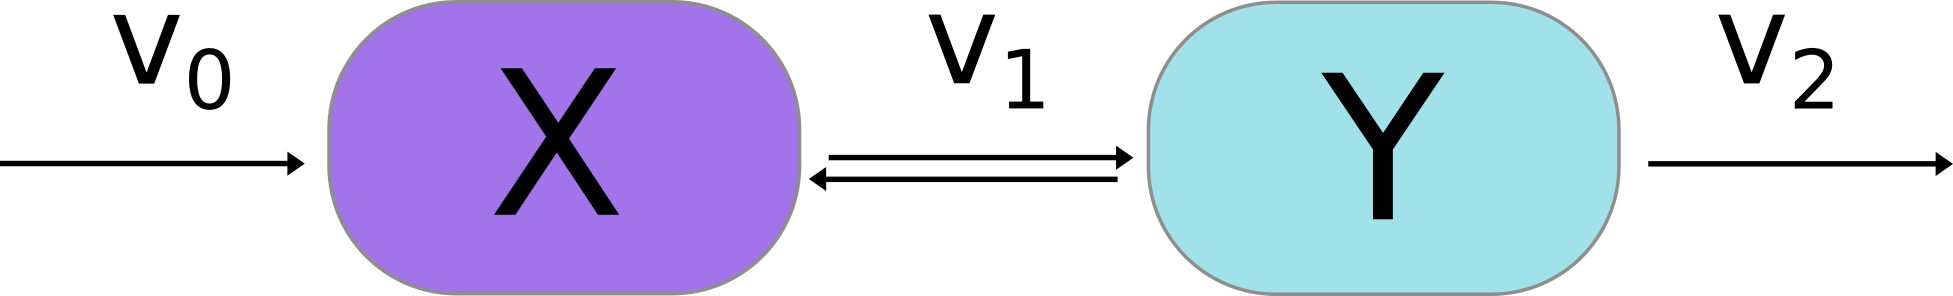

where the rate of v1 can be described as $v_1 = k_{1p}*[X] - k_{1m}*[Y]$

In [237]:
# Provide now 4 parameters with k1 forward and backward
p = {'v0':1,
     'k1p':0.5,
     'k1m':1,
     'k2':0.1}

In [240]:
# Reinstantiate model with the new parameter set
m = modelbase.Model(p)

In [242]:
# Add compounds, unchanged reactions v1 and v2 and set stoichiometries for them
m.set_cpds(cl)

m.set_rate('v0',lambda p:p.v0)
m.set_stoichiometry('v0',{'X':1})

m.set_rate('v2',v2,'Y')
m.set_stoichiometry('v2',{'Y':-1})

In [243]:
# Redefine the kinetics of v1 with a reversible mass-action kinetics
def v1(p,x,y):
    return p.k1p*x - p.k1m*y

m.set_rate('v1',v1,'X','Y') # tells the model to pass concentrations of X and Y
m.set_stoichiometry('v1',{'X':-1,'Y':1}) # one X destroyed, one Y created

In [244]:
# Check the current stoichiometry
m.stoichiometries

{'v0': {'X': 1}, 'v1': {'X': -1, 'Y': 1}, 'v2': {'Y': -1}}

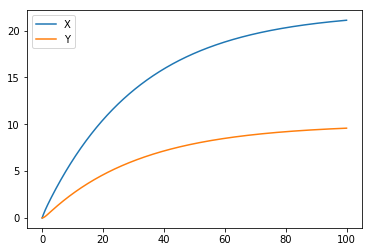

In [245]:
# create modelbase.simulate.Simulate object
s = modelbase.Simulate(m)
# run a timecourse
s.timeCourse(np.linspace(0,100,1000),np.zeros(2))

#plt.interactive(True)
plt.figure()
plt.plot(s.getT(),s.getY())
plt.legend(m.cpdNames)
plt.xlabel('time [s]')
plt.ylabel('protein concentration [a.u.]')
plt.draw_if_interactive()
plt.show()


---
### Example 2: Modelling a simple chain of reactions using a rapid equilibrium approximation
This example illustrates how to simulate a simple chain of three reactions where one of the reactions is assumed to operate on much faster time scale than other reactions and therefore can be assumed to be in an equilibrium.

In the reaction chain:
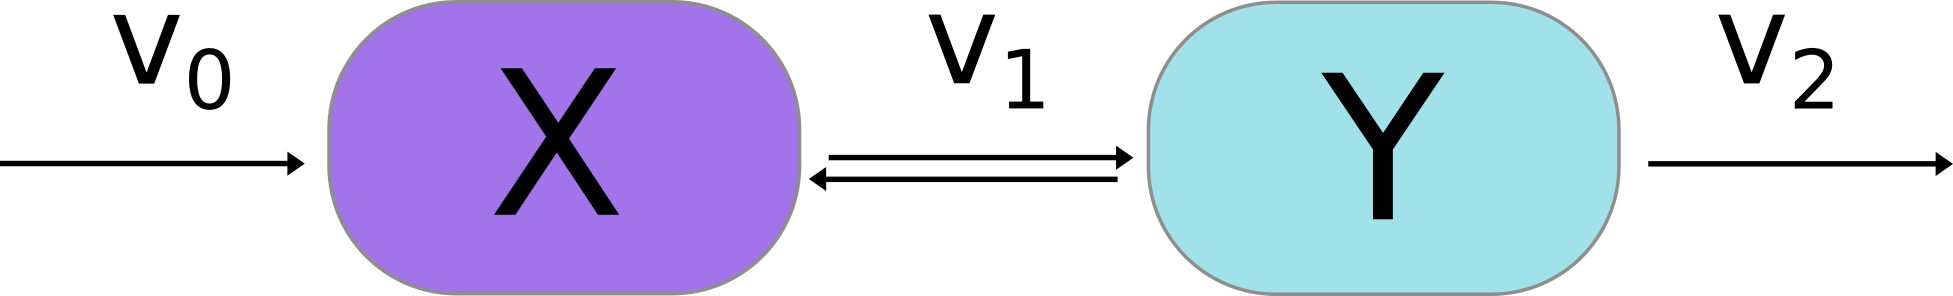
$X \Longleftrightarrow Y$ is assumed to be very fast, i.e. in equilibrium.

Approach: 
1. We define one 'slow' variable A (where A = X+Y).
2. We define the **algebraic module**, allowing to calculate X and Y from A.
3. We can use any quantity A, X, Y in our rate equations.

In [246]:
# define slow variable A
cl = ['A']
p = {'v0':1,'k2':0.1}

In [247]:
# instantiate model as AlgmModel (because it uses an algebraic module)
m = modelbase.AlgmModel(p)

In [248]:
m.set_cpds(cl)

In [249]:
# this function defines the algebraic module. It accepts as first argument
# the parameters, then the slow-changing variable
# output are the two derived variables X and Y
def feq(par,y):
    return np.array([y[0]/(1+par.K),y[0]*par.K/(1+par.K)])

In [250]:
# define the algebraic module object
eqm = modelbase.algebraicModule.AlgebraicModule({'K':5},feq)

# add it to the model by specifying the names of the variables
m.add_algebraicModule(eqm,['A'],['X','Y'])


# constant influx to the pool A
m.set_rate('v0',lambda p:p.v0)
m.set_stoichiometry('v0',{'A':1})

# mass-action outflux from the pool A
# note that rate expression depends on variable Y!
def v2(p,y):
    return p.k2*y

m.set_rate('v2',v2,'Y')
m.set_stoichiometry('v2',{'A':-1})

In [251]:
# use the AlgmSimulate class to get access to the variables X and Y
s = modelbase.AlgmSimulate(m)
s.timeCourse(np.linspace(0,100,1000),np.zeros(1))

array([[  0.        ],
       [  0.09968376],
       [  0.19853944],
       [  0.29657394],
       [  0.39379406],
       [  0.49020658],
       [  0.5858182 ],
       [  0.68063558],
       [  0.77466531],
       [  0.86791394],
       [  0.96038795],
       [  1.05209379],
       [  1.14303782],
       [  1.23322639],
       [  1.32266576],
       [  1.41136216],
       [  1.49932176],
       [  1.58655068],
       [  1.67305499],
       [  1.75884071],
       [  1.84391382],
       [  1.92828022],
       [  2.01194579],
       [  2.09491636],
       [  2.17719769],
       [  2.25879551],
       [  2.3397155 ],
       [  2.41996328],
       [  2.49954446],
       [  2.57846455],
       [  2.65672905],
       [  2.73434341],
       [  2.81131304],
       [  2.88764327],
       [  2.96333944],
       [  3.03840679],
       [  3.11285057],
       [  3.18667594],
       [  3.25988804],
       [  3.33249197],
       [  3.40449279],
       [  3.47589549],
       [  3.54670506],
       [  3

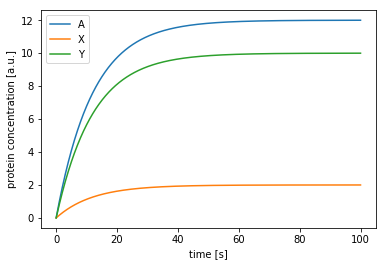

In [254]:
plt.figure()
plt.plot(s.getT(),s.getY())
plt.legend(m.allCpdNames())
plt.xlabel('time [s]')
plt.ylabel('protein concentration [a.u.]')
plt.draw_if_interactive()
plt.show()

---
### Example 3: Modelling a system with a time dependent external conditions

---
### Example 4: Modelling a simple protein kinase signalling cascade.

A mitogen-activated protein kinase (MAP kinase) is a type of protein kinase that is specific to the amino acids serine and threonine. MAPKs are involved in directing cellular responses to a diverse array of stimuli, such as mitogens, osmotic stress, heat shock and proinflammatory cytokines. They regulate cell functions including proliferation, gene expression, differentiation, mitosis, cell survival, and apoptosis. MAPKs typically form multi-tiered pathway. Modelbase allows to simulate the change in concentration of each protein kinase.
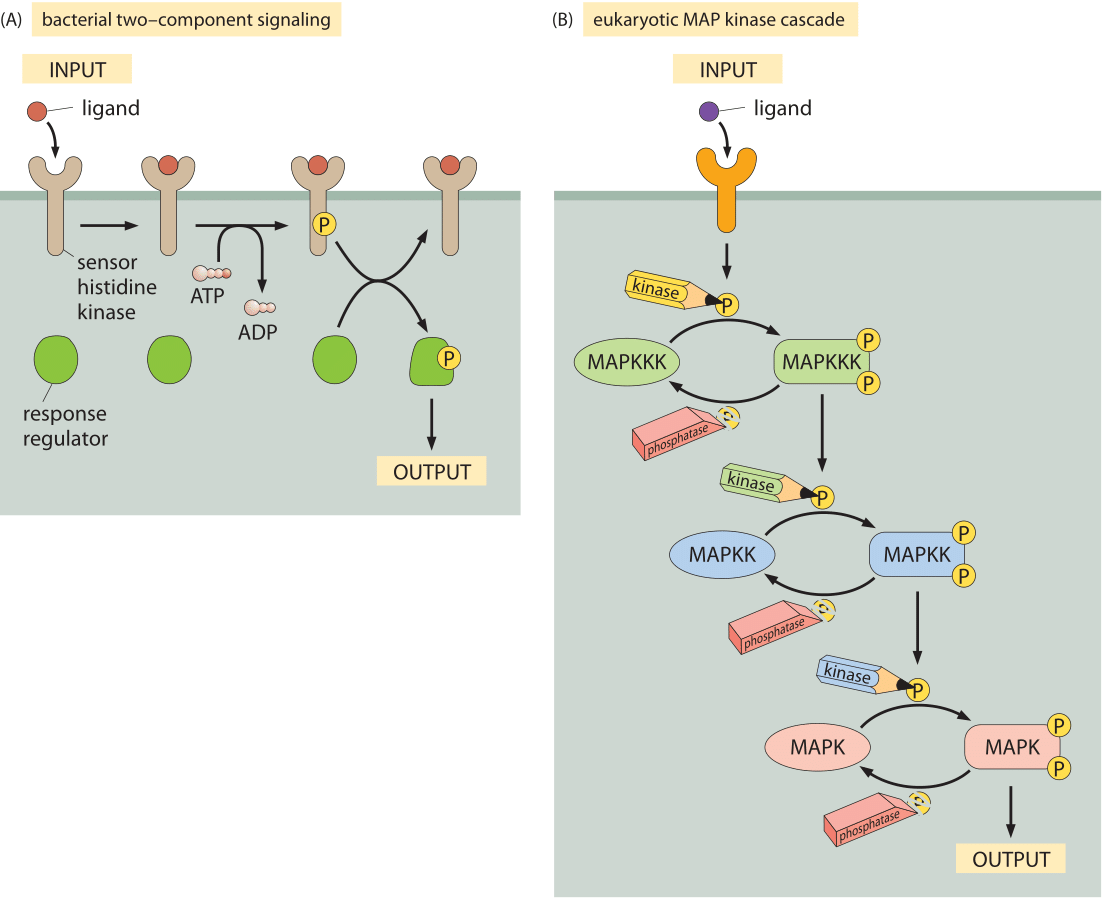


It employs time-dependent external stimulus and illustrates how to use algebraic modules for conserved quantitites

Here: Three protein kinases X, Y, Z. 
    R(t)
     v
  Xi -> X
        v
     Yi -> Y
           v
        Zi -> Z
        
Reversion X/Y/Z -> Xi/Yi/Zi as mass-action
{XYZ}i is inactive form, {XYZ} active form

Three conserved quantitites:
    X + Xi = Xtot
    Y + Yi = Ytot
    Z + Zi = Ztot

Algebraic modules calculate {XYZ}i from {XYZ}

#### Model assumptions
Let's assume that three protein kinases X, Y, Z. Define the dynamic variables.
Three conserved quantitites:
    X + Xi = Xtot
    Y + Yi = Ytot
    Z + Zi = Ztot

Reversion X/Y/Z -> Xi/Yi/Zi as mass-action
{XYZ}i is inactive form, {XYZ} active form

Let's assume that all the reaction rates are set to 1 and are equal to 0.5 a.u. [arbitrary units]

In [16]:
cl = ['X','Y','Z']

In [20]:
# Provide parameters set in a form of dictionary
p = {'l':.5, 'k1':1., 'k2':1., 'k3':1., 'p':.5}

In [21]:
# Instantiate the model
m = modelbase.AlgmModel(p)

In [27]:
# Set the compounds
m.set_cpds(cl)

In [28]:
# Define the algebraic module exploiting conserved quantitites
def conrel(par, y):
        return np.array([par.tot - y[0]])

In [29]:
# Add three algebraic modules, always returning the inactive form Xi, etc.
cr = modelbase.algebraicModule.AlgebraicModule({'tot':1}, conrel)
m.add_algebraicModule(cr,['X'],['Xi'])
m.add_algebraicModule(cr,['Y'],['Yi'])
m.add_algebraicModule(cr,['Z'],['Zi'])

In [30]:
# Define the time-dependent stimulus and set the rate (see Exercise 2)
# Note that rate of conversion depends on Xi (made accessible by algebraic module)
def v0(p,x,**kwargs):
    return x*np.exp(-p.l*kwargs['t'])

m.set_ratev('v0',v0,'Xi')
m.set_stoichiometry('v0',{'X':1})

In [32]:
# Define the kinases
def k1(p,x,y0):
    return p.k1*x*y0

m.set_rate('k1',k1,'X','Yi')
m.set_stoichiometry('k1',{'Y':1})

In [33]:
def k2(p,x,y0):
    return p.k2*x*y0

m.set_rate('k2',k2,'Y','Zi')
m.set_stoichiometry('k2',{'Z':1})

In [34]:
# Define the constitutively active, unspecific phosphatase
def phosph(p,x):
    return p.p * x

In [35]:
# Set the stoichiometry (here by the rate, alternatively the stoichiometry can be set by the compound name)
m.set_rate('p1',phosph,'X')
m.set_stoichiometry('p1',{'X':-1})

m.set_rate('p2',phosph,'Y')
m.set_stoichiometry('p2',{'Y':-1})

m.set_rate('p3',phosph,'Z')
m.set_stoichiometry('p3',{'Z':-1})

In [40]:
# Integrate the system over the time of 1 minute
s = modelbase.Simulate(m)
s.timeCourse(np.linspace(0,60,500),np.zeros(3))

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.06930237e-01,   6.52819830e-03,   2.64439041e-04],
       [  1.91236964e-01,   2.35202686e-02,   1.92632234e-03],
       ..., 
       [  6.02810861e-12,   1.71275476e-10,   3.22363724e-09],
       [  5.68832517e-12,   1.61965024e-10,   3.05497587e-09],
       [  5.36767046e-12,   1.53159310e-10,   2.89509918e-09]])

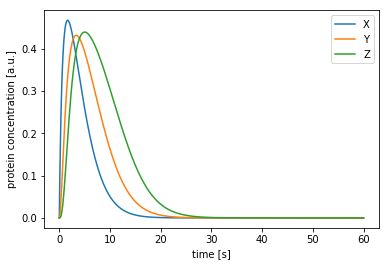

In [42]:
# Plot the temporal evolution of the protein kinase
plt.figure()
plt.plot(s.getT(),s.getVarsByName(cl))
plt.legend(cl)
plt.xlabel('time [s]')
plt.ylabel('protein concentration [a.u.]')
plt.draw_if_interactive()
plt.show()

***

## Labeling extension